<a href="https://colab.research.google.com/github/snmsndhu/google_colab_files/blob/main/x_ray_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chest X-ray Images classification

In this notebook, i am going to build a Image classification Model which will take a image of the X-ray and predicts whether
it ha Pneumonia or not.

In [1]:
# First we need to load the dataset and we need to install the kagel and load the dataset from it

!pip install kaggle


In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets list

ref                                                   title                                           size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
rahulvyasm/netflix-movies-and-tv-shows                Netflix Movies and TV Shows                      1MB  2024-04-10 09:48:38           2686         54  1.0              
sudarshan24byte/online-food-dataset                   Online Food Dataset                              3KB  2024-03-02 18:50:30          29420        567  0.9411765        
akankshaaa013/top-grossing-movies-dataset             Top Grossing Movies Dataset                     33KB  2024-04-08 08:29:47           1404         32  1.0              
mexwell/heart-disease-dataset                         🫀 Heart Disease Dataset                        399KB  2024-04-08 09:43:49        

In [6]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:16<00:00, 164MB/s]
100% 2.29G/2.29G [00:16<00:00, 147MB/s]


In [7]:
! unzip chest-xray-pneumonia.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: /content/data/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
 

 So our data download from the kaggel is ready to use, so now we can load the data and do the preprocessing.
 For that Tensorflow keras highlevel api will be used

In [8]:
# First let's do all the important imports

import tensorflow as tf
import numpy as np

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [9]:
train_dir = "/content/data/chest_xray/train"
test_dir = "/content/data/chest_xray/test"

In [10]:
# Let's load the data to preprocess it

batch_size = 32
img_height = 180
img_widht = 180

In [11]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    seed = 42,
    image_size = (img_height, img_widht),
    batch_size= batch_size
)

Found 5216 files belonging to 2 classes.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_widht),
  batch_size=batch_size)

Found 624 files belonging to 2 classes.


In [13]:
class_names = train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mping
import random
import os

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mping.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image Shape: {img.shape}")

  return img



Image Shape: (1496, 2148)


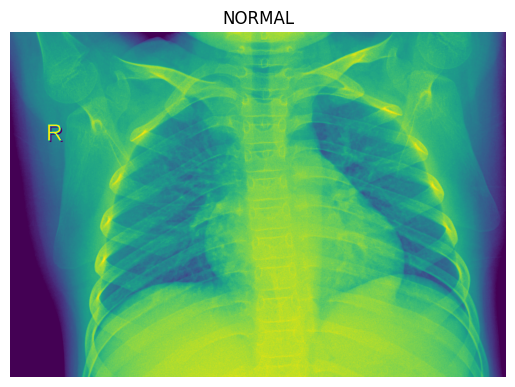

In [26]:
img = view_random_image(target_dir="/content/data/chest_xray/train/",
                        target_class="NORMAL")

In [27]:
img

array([[77, 78, 78, ..., 30, 27, 24],
       [76, 76, 76, ..., 30, 27, 23],
       [81, 78, 75, ..., 30, 27, 24],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [28]:
img.shape

(1496, 2148)

In [29]:
img/255.

array([[0.30196078, 0.30588235, 0.30588235, ..., 0.11764706, 0.10588235,
        0.09411765],
       [0.29803922, 0.29803922, 0.29803922, ..., 0.11764706, 0.10588235,
        0.09019608],
       [0.31764706, 0.30588235, 0.29411765, ..., 0.11764706, 0.10588235,
        0.09411765],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

### So our data loading is done and processing the size and making the batches every thing is done in one function

## Let's build our model


In [14]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_widht, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomBrightness(0.1),
        layers.RandomContrast(0.1),
    ]
)

In [15]:
num_classes = len(class_names)

model = keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

In [16]:
# Compile our model

model.compile(optimizer="adam",
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics = ["accuracy"])

In [17]:
epochs = 10

history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = epochs
)

Epoch 1/10
163/163 [==============================] - 49s 238ms/step - loss: 0.6241 - accuracy: 0.7337 - val_loss: 0.6338 - val_accuracy: 0.6250
Epoch 2/10
163/163 [==============================] - 38s 221ms/step - loss: 0.5313 - accuracy: 0.7504 - val_loss: 0.4274 - val_accuracy: 0.8446
Epoch 3/10
163/163 [==============================] - 38s 221ms/step - loss: 0.4102 - accuracy: 0.8133 - val_loss: 0.3725 - val_accuracy: 0.8494
Epoch 4/10
163/163 [==============================] - 37s 220ms/step - loss: 0.3544 - accuracy: 0.8424 - val_loss: 0.3268 - val_accuracy: 0.8766
Epoch 5/10
163/163 [==============================] - 37s 215ms/step - loss: 0.2809 - accuracy: 0.8850 - val_loss: 0.2988 - val_accuracy: 0.8830
Epoch 6/10
163/163 [==============================] - 38s 216ms/step - loss: 0.2577 - accuracy: 0.8999 - val_loss: 0.4009 - val_accuracy: 0.8494
Epoch 7/10
163/163 [==============================] - 38s 222ms/step - loss: 0.2370 - accuracy: 0.9049 - val_loss: 0.3666 - val_ac

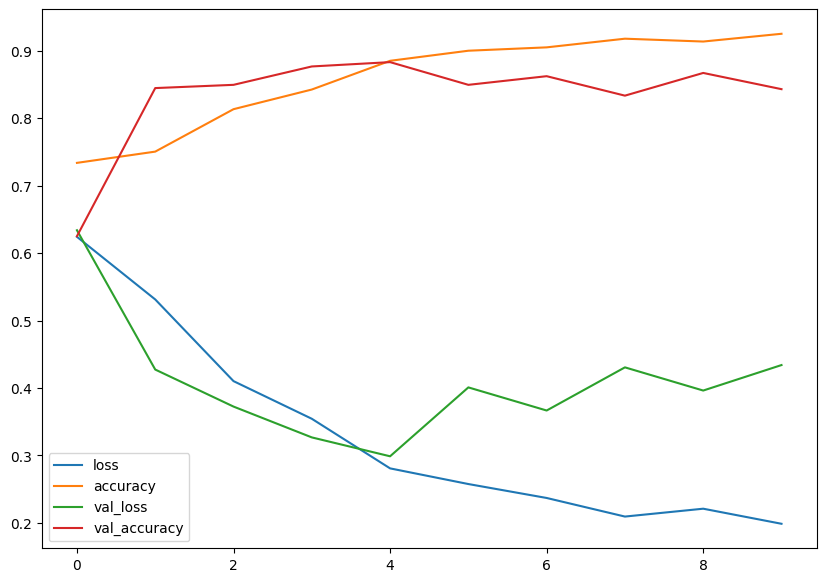

In [32]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(10, 7));

Our cruves are looking good but our validation curve is slighty increasing that leads us to the overfitting.
Lets seperate this curves and visualize them in better way.

In [30]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


  plt.figure()
  plt.plot(epochs, accuracy, label= "training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

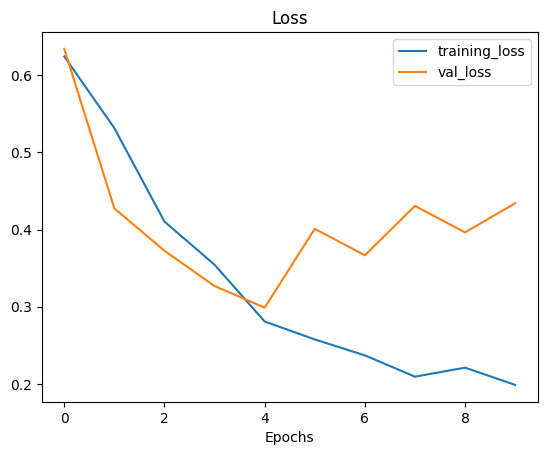

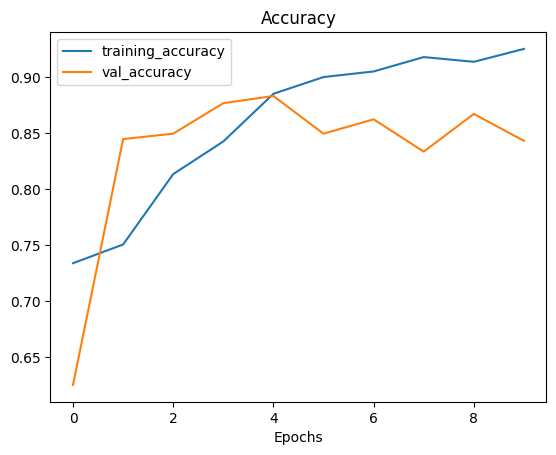

In [31]:
plot_loss_curves(history)

 It Looks like our model is overfitting, the ideal position for the these two curves should be slightly under the training curve

In [18]:
photo_path = "/content/data/chest_xray/val/NORMAL/NORMAL2-IM-1431-0001.jpeg"

In [19]:

# sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    photo_path, target_size=(img_height, img_widht)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
predictions
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 341ms/step
This image most likely belongs to NORMAL with a 50.38 percent confidence.


In [22]:
model.save("model")

In [21]:
!zip -r /content/model.zip /content/model/

  adding: content/model/ (stored 0%)
  adding: content/model/saved_model.pb (deflated 88%)
  adding: content/model/assets/ (stored 0%)
  adding: content/model/variables/ (stored 0%)
  adding: content/model/variables/variables.index (deflated 66%)
  adding: content/model/variables/variables.data-00000-of-00001 (deflated 37%)
  adding: content/model/fingerprint.pb (stored 0%)
  adding: content/model/keras_metadata.pb (deflated 93%)
